In [1]:
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.append(os.environ['DH_DIR'])

import numpy as np
from scipy import integrate
import pickle

import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('matplotlibrc')

## 0. utilities

In [2]:
# constants
EPSILON = 1e-100
Mpc = 3.08568e24 # cm

# utilities
def logspace(a, b, n):
    arr = np.logspace(np.log10(a), np.log10(b), n)
    arr[0] = a
    arr[-1] = b
    return arr
def range_wend(a, b, step=1):
    return range(a, b+1, step)

# plotting
def tento_label(expns):
    return [r'$10^{'+str(expn)+r'}$' for expn in expns]

## 1. photon cross sections & rates

$$\Gamma_\text{int}=\frac{dN}{dt}=nc\int\frac{d\sigma}{dE'}\Big|_{E'}dE'$$
$$\Gamma_\text{cool}\equiv t_\text{cool}^{-1}=\left|\frac{d\log E}{dt}\right|=\frac{1}{E}\left|\frac{dE}{dt}\right|=\frac{nc}{E}\int|\Delta E'|\frac{d\sigma}{dE'}\Big|_{E'}dE'$$

In [3]:
def pp_CMB_rate(Ep, rs): # s^-1(eV, 1)
    
    # Ep: hard, ep: soft
    epmin = (1+1e-10) * phys.me**2 / Ep
    epmax = 500*phys.TCMB(rs)
    if epmax <= epmin:
        return 0
    eng_CMB = logspace(epmin, epmax, 100) # eV
    eng_CMB_binbounds = spectools.get_bin_bound(eng_CMB) # eV
    eng_CMB_binwidths = eng_CMB_binbounds[1:] - eng_CMB_binbounds[:-1] # eV
    dndE_CMB = phys.CMB_spec(eng_CMB, phys.TCMB(rs)) # cm^-3 eV^-1
    dN_dEdt_arr = [] # eV^-1 s^-1
    
    for ep, dndE in zip(eng_CMB, dndE_CMB):
        
        E = Ep / phys.me # 1(E/me) | input hard photon energy
        e = ep / phys.me # 1(E/me) | CMB soft photon energy
        A = E + e
        
        def integrand(Ee): # 1(1) | Ee in units of me | numerical factor in parentheses in Eq.(C1) in 0906.1197
            return ( (4*A**2*np.log(4*e*Ee*(A-Ee)/A)) / (Ee*(A-Ee))
                     - 8*e*A + (2*(2*e*A-1)*A**2) / (Ee*(A-Ee))
                     - (1-1/(e*A))*(A**4)/(Ee**2*(A-Ee)**2) )
        intg, err = integrate.quad(integrand, A/2*(1-np.sqrt(1-1/(E*e))), A/2*(1+np.sqrt(1-1/(E*e))))
        if np.abs(err/intg) > 1e-5:
            raise ValueError('Large integration error.')
        # dN/dEdt | eV^-1 s^-1 = cm^2 * cm/s * 1 * cm^-3 eV^-1
        dN_dEdt = phys.thomson_xsec * phys.c * (3/64) * (1/(e**2 * E**3)) * intg * dndE
        dN_dEdt_arr.append(dN_dEdt)
        
    rate = np.dot(dN_dEdt_arr, eng_CMB_binwidths) # s^-1
    return rate

In [4]:
def pp_matter_rate(Ep, rs, xHII=None, xHeII=None, xHeIII=None): # s^-1(eV, 1) | vectorized in Ep
    
    if xHII is None:
        xHII = phys.xHII_std(rs)
    if xHeII is None:
        xHeII = phys.xHeII_std(rs)
    if xHeIII is None:
        xHeIII = 0
        
    ref_rate = phys.alpha * phys.ele_rad**2 * phys.c * phys.nH * rs**3 # s^-1 = cm^2 * cm/s * cm^-3 | reference cross section
    
    # rate s^-1 = cm^2 * cm/s * cm^-3
    rate_xHII   = ref_rate * np.clip((28/9)*np.log(2*Ep/phys.me)-(218/27), 0, None) * xHII
    rate_xHeII  = ref_rate * np.clip((28/9)*np.log(2*Ep/phys.me)-(218/27), 0, None) * xHeII
    rate_xHeIII = ref_rate * np.clip((28/9)*np.log(2*Ep/phys.me)-(218/27), 0, None) * xHeIII # placeholder
    rate_elec   = ref_rate * np.clip((28/9)*np.log(2*Ep/phys.me)-(100/9),  0, None) * (xHII + xHeII + 2*xHeIII)
    rate_xHI    = ref_rate * 5.4  * np.log(513*Ep/(Ep+825*phys.me)) * (1 - xHII)
    rate_xHeI   = ref_rate * 8.76 * np.log(513*Ep/(Ep+825*phys.me)) * (phys.nHe/phys.nH - xHeII - xHeIII)
    return rate_xHII + rate_xHeII + rate_xHeIII + rate_elec + rate_xHI + rate_xHeI

### pair production on fully ionized matter
1989ApJ...344..551Z (Zdziarski and Svensson 1989, Eq.5.9-10)
$$\frac{d\tau}{dl}=\frac{d\tau}{c_0dt}=\frac{1}{c_0}\Gamma=n_\text{target}\sigma$$
$$\frac{d\tau}{d\tilde{l}}=\frac{20}{3}n_e^0(1+z)^3\alpha_f r_0^2\frac{c_0}{H_0}\left(\log2\epsilon-\frac{109}{42}\right)$$
where, $d\tilde l = \frac{H_0}{c_0}dl$, $\epsilon = E/m_e$, $\alpha_f=1/137$, $r_0$ is electron classical radius.
$$\Gamma=c_0\frac{d\tau}{dl}=c_0\frac{H_0}{c_0}\frac{d\tau}{d\tilde l}=\frac{20}{3}n_e^0(1+z)^3\alpha_f r_0^2c_0\left(\log2\epsilon-\frac{109}{42}\right)$$

In [5]:
def pp_matter_fullion_ZS_rate(Ep, rs): # s^-1(eV, 1)
    # s^-1 = cm^3 * cm^2 * cm s^-1
    rate = 20/3 * (phys.nH+2*phys.nHe) * rs**3 * phys.alpha * phys.ele_rad**2 * phys.c * \
           (np.log(2*Ep/phys.me) - 109/42)
    return np.clip(rate, 0, None)

In [6]:
def phph_scat_rate(Ep, rs): # s^-1(eV, 1) | vectorized in Ep
    # s^-1 = 1 * s^-1 * 1
    return 1.83e-27 * (2*phys.h)**(-1) * (phys.TCMB(1)/(2.7*phys.kB))**6 \
           * phys.H0 * rs**6 * (Ep/phys.me)**3

def phph_scat_cool_rate(Ep, rs): # s^-1(eV, 1) | vectorized in Ep
    E = Ep/phys.me
    def integrand(Ef): # 1(1)
        return (1-(Ef/E)+(Ef/E)**2)**2 * (E-Ef)
    intg, err = integrate.quad(integrand, E/2, E)
    if np.abs(err/intg) > 1e-5:
        raise ValueError('Large integration error.')
    return phph_scat_rate(Ep, rs) * (20/7) * intg / E**2

In [7]:
def compton_rate(Ep, rs): # s^-1(eV, 1)
    E = Ep/phys.me
    def integrand(Ef): # 1(1)
        return Ef/E + E/Ef - 1 + (1 - (1/Ef - 1/E))**2
    intg, err = integrate.quad(integrand, E/(1+2*E), E)
    if np.abs(err/intg) > 1e-5:
        raise ValueError('Large integration error.')
    sigma = np.pi * phys.alpha**2 * (phys.ele_compton/(2*np.pi))**2 * (1/E**2) * intg # cm^2
#     if E < 1:
#         sigma *= E
    return sigma * phys.c * (phys.nH + 2*phys.nHe) * rs**3

def compton_cool_rate(Ep, rs): # s^-1(eV, 1)
    E = Ep/phys.me
    def integrand(Ef): # 1(1)
        return (Ef/E + E/Ef - 1 + (1 - (1/Ef - 1/E))**2) * (E-Ef)
    intg, err = integrate.quad(integrand, E/(1+2*E), E)
    if np.abs(err/intg) > 1e-5:
        raise ValueError('Large integration error.')
    sigma = np.pi * phys.alpha**2 * (phys.ele_compton/(2*np.pi))**2 * (1/E**2) * intg / E # cm^2
    return sigma * phys.c * (phys.nH + 2*phys.nHe) * rs**3

In [8]:
def photoion_rate(Ep, rs): # s^-1(eV, 1)
    
    def sigma_1e(E, Eth): # cm^2(eV, eV)
        if E <= Eth:
            return 0
        eta = 1/(np.sqrt(E/Eth) - 1)
        return (2**9*np.pi**2*phys.ele_rad**2)/(3*phys.alpha**3) * (Eth/E)**4 \
               * np.exp(-4*eta*np.arctan(1/eta)) / (1 - np.exp(-2*np.pi*eta))
    
    def sigma_HeII(E): # cm^2(eV)
        if E < 50: # eV
            return 0
        expn = -3.30 if E > 250 else -2.65
        return -12*sigma_1e(E, 13.6) + 5.1e-20 * (E/250)**expn # cm^2
    
    rate_xHI   = sigma_1e(Ep, 13.6) * phys.c * phys.nH * rs**3 * (1 - phys.xHII_std(rs))
    rate_xHeII = sigma_1e(Ep, 54.4) * phys.c * phys.nH * rs**3 * phys.xHeII_std(rs)
    rate_xHeI  = sigma_HeII(Ep) * phys.c * phys.nH * rs**3 * (phys.nHe/phys.nH - phys.xHeII_std(rs))
    
    return rate_xHI + rate_xHeII + rate_xHeI

## 2. plot rates

In [10]:
# define grid
Ep_s = logspace(1e2, 1e13, 100)
rs_s = logspace(10, 3000, 100)
x_ss, y_ss = np.meshgrid(np.log10(Ep_s), np.log10(rs_s))

hubble_ss = np.zeros((len(rs_s), len(Ep_s)))
a_ss      = np.zeros((len(rs_s), len(Ep_s)))
for i, rs in enumerate(rs_s):
    for j, Ep in enumerate(Ep_s):
        hubble_ss[i,j] = phys.hubble(rs)
        a_ss[i,j] = 1/rs

In [19]:
# save rates
funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, phph_scat_cool_rate,
         compton_rate, compton_cool_rate, photoion_rate]
vectorize = False

for func in funcs:
    print(func.__name__, flush=True)
    ss = []
    for rs in tqdm(rs_s):
        s = []
        if vectorize:
            ss.append(func(Ep_s, rs))
        else:
            for Ep in Ep_s:
                s.append(func(Ep, rs))
            ss.append(s)
    np.save('rates/'+func.__name__, np.array(ss))

pp_CMB_rate


100%|██████████| 100/100 [06:58<00:00,  4.19s/it]

pp_matter_rate



100%|██████████| 100/100 [00:01<00:00, 69.02it/s]

phph_scat_rate



100%|██████████| 100/100 [00:00<00:00, 5475.66it/s]

phph_scat_cool_rate



100%|██████████| 100/100 [00:00<00:00, 224.10it/s]

compton_rate



100%|██████████| 100/100 [00:06<00:00, 15.42it/s]

compton_cool_rate



100%|██████████| 100/100 [00:07<00:00, 14.13it/s]

photoion_rate



100%|██████████| 100/100 [00:01<00:00, 83.85it/s]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


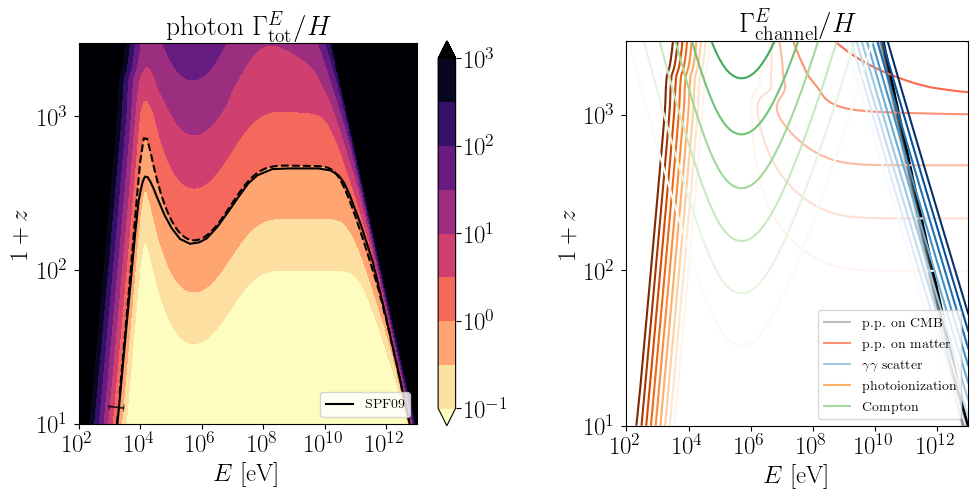

In [11]:
# plot rates
plot_cool = True
fig, axs = plt.subplots(1, 2, figsize=(12,5))

if plot_cool:
    names = ['pp_CMB', 'pp_matter', 'phph_scat', 'photoion', 'compton_cool']
    title_left = r'photon $\Gamma^E_\mathrm{tot}/H$'
    title_right = r'$\Gamma^E_\mathrm{channel}/H$'
else:
    names = ['pp_CMB', 'pp_matter', 'phph_scat', 'photoion', 'compton']
    title_left  = r'photon $\Gamma_\mathrm{tot}/H$'
    title_right = r'$\Gamma_\mathrm{channel}/H$'
rates = [np.load(f'rates/{name}_rate.npy') for name in names]
ratio = np.clip(np.sum(rates, axis=0), 1e-100, None) / np.array(hubble_ss)

levels = np.linspace(-1, 3, 9)
im = axs[0].contourf(x_ss, y_ss, np.log10(ratio), cmap='magma_r', levels=levels, extend='both')
cs = axs[0].contour( x_ss, y_ss, np.log10(ratio), colors='k', linestyles='--',
                     levels=np.log10([1]), extend='both')
axs[0].clabel(cs, cs.levels, fmt={cs.levels[0]: '1'})
cbar = fig.colorbar(im, ax=axs[0], spacing='proportional', ticks=range_wend(-1, 3))
cbar.ax.set_yticklabels(tento_label(range_wend(-1, 3)))
if plot_cool:
    x_t, y_t = np.loadtxt('rates/SPF09/tcool_tH_1.txt', unpack=True)
    axs[0].plot(x_t, y_t, 'k', label='SPF09')
    axs[0].legend(loc='lower right', fontsize=10)
axs[0].set_aspect(5)
axs[0].set_xticks(range_wend(2, 12, 2))
axs[0].set_xticklabels(tento_label(range_wend(2, 12, 2)))
axs[0].set_yticks(range_wend(1, 3))
axs[0].set_yticklabels(tento_label(range_wend(1, 3)))
axs[0].set(title=title_left, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')

labels = ['p.p. on CMB', 'p.p. on matter', r'$\gamma\gamma$ scatter', 'photoionization', 'Compton']
cmaps = ['Greys', 'Reds', 'Blues', 'Oranges', 'Greens']
for i, rate in enumerate(rates):
    ratio = np.clip(rate, 1e-100, None) / np.array(hubble_ss)
    cs = axs[1].contour(x_ss, y_ss, np.log10(ratio), cmap=cmaps[i], levels=levels, extend='both')
    if i != 20:
        cs.collections[3].set_label(labels[i])
axs[1].set_aspect(5)
axs[1].set_xticks(range_wend(2, 12, 2))
axs[1].set_xticklabels(tento_label(range_wend(2, 12, 2)))
axs[1].set_yticks(range_wend(1, 3))
axs[1].set_yticklabels(tento_label(range_wend(1, 3)))
axs[1].set(title=title_right, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
axs[1].legend(fontsize=10, loc='lower right')

if plot_cool:
    fig.savefig('cool_rate.pdf')
else:
    fig.savefig('int_rate.pdf')

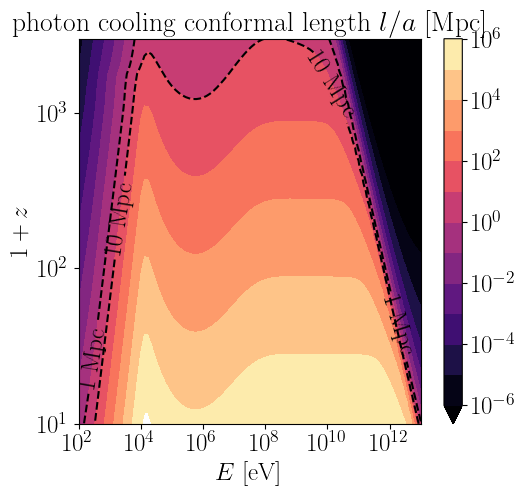

In [27]:
# plot optical depth
fig, ax = plt.subplots(figsize=(6,5))

plot_cool = True
if plot_cool:
    names = ['pp_CMB', 'pp_matter', 'phph_scat', 'photoion', 'compton_cool']
    title = r'photon cooling conformal length $l/a$ [Mpc]'
else:
    names = ['pp_CMB', 'pp_matter', 'phph_scat', 'photoion', 'compton']
    title = r'photon scattering conformal length $l/a$ [Mpc]'
rates = [np.load(f'rates/{name}_rate.npy') for name in names]

Mpc = 3.08568e24 # cm
cfdepth = phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) / a_ss / Mpc # Mpc

levels = np.linspace(-6, 6, 13)
im = ax.contourf(x_ss, y_ss, np.log10(cfdepth), cmap='magma', levels=levels, extend='min')
cs = ax.contour( x_ss, y_ss, np.log10(cfdepth), colors='k', linestyles='--',
                 levels=np.log10([1, 10]), extend='both')
ax.clabel(cs, cs.levels, fmt={cs.levels[0]: '1 Mpc', cs.levels[1]: '10 Mpc'})
cbar = fig.colorbar(im, ax=ax, spacing='proportional', ticks=range_wend(-6, 6, 2))
cbar.ax.set_yticklabels(tento_label(range_wend(-6, 6, 2)))

ax.set_aspect(5)
ax.set_xticks(range_wend(2, 12, 2))
ax.set_xticklabels(tento_label(range_wend(2, 12, 2)))
ax.set_yticks(range_wend(1, 3))
ax.set_yticklabels(tento_label(range_wend(1, 3)))
ax.set(title=title, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')

if plot_cool:
    fig.savefig('cool_cfm_length.pdf')
else:
    fig.savefig('int_cfm_length.pdf')

## 3. rates at one slice

In [29]:
Ep_s = logspace(1e3, 1e12, 100)
rs = 1001
rate_ss = []
for func in [pp_CMB_rate, phph_scat_rate, photoion_rate, compton_cool_rate,
             lambda Ep, rs: pp_matter_rate(Ep, rs, 1, 0, phys.nHe/phys.nH),
             lambda Ep, rs: pp_matter_rate(Ep, rs, 0, 0, 0),
             pp_matter_fullion_ZS_rate]:
    rate_ss.append([func(Ep, rs) for Ep in Ep_s])
    print('.', end='', flush=True)
rate_ss = np.array(rate_ss)
ratio_ss = rate_ss / phys.hubble(rs)

.......

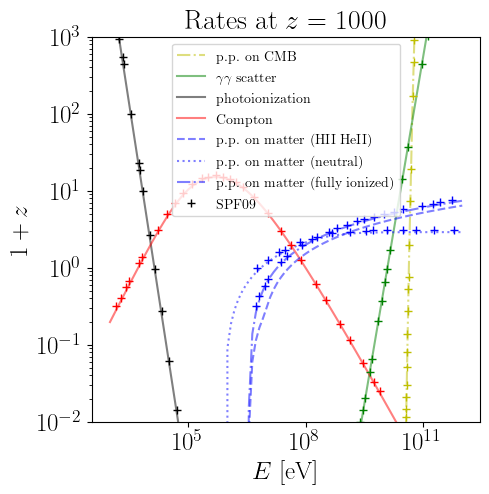

In [37]:
# plot optical depth
fig, ax = plt.subplots(figsize=(5,5))

plot_cool = True
if plot_cool:
    title = r'photon $\Gamma^E_\mathrm{tot}/H$ at $z=1000$'
else:
    title = r'photon $\Gamma_\mathrm{tot}/H$ at $z=1000$'

styles     = ['y-.', 'g-', 'k-', 'r-', 'b--', 'b:', 'b-.']
styles_spf = ['y+',  'g+', 'k+', 'r+', 'b+',  'b+', 'b+' ]
spf_fns = ['pp_CMB', 'phph_scat', 'photoion', 'compton', 'pp_matter_HII_HeII', 'pp_matter_neutral']
labels = ['p.p. on CMB', r'$\gamma\gamma$ scatter', 'photoionization', 'Compton',
          'p.p. on matter (HII HeII)', 'p.p. on matter (neutral)', 'p.p. on matter (fully ionized)']

labels_spf = ['', '', 'SPF09', '', '', '', '']

for i in range(7):
    ax.plot(Ep_s, ratio_ss[i], styles[i], label=labels[i], alpha=0.5)
for i in range(6):
    x, y = np.loadtxt('rates/SPF09/'+spf_fns[i]+'.txt', unpack=True)
    ax.plot(10**x, 10**y, styles_spf[i], label=labels_spf[i])
ax.set(xscale='log', yscale='log')
ax.set(ylim=(1e-2,1e3))
ax.legend(fontsize=10)

ax.set(title=r'Rates at $z=1000$', xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
fig.savefig('z1000rates.pdf')

## Archive

In [ ]:
# darkhistory rate
hep_tf = pickle.load(open(os.environ['DH_DATA_DIR']+'/highengphot_tf_interp.raw', 'rb'))
dh_rate_ss = np.zeros((len(rs_s), len(Ep_s)))
for i, rs in tqdm(enumerate(rs_s)):
    xH  = phys.xHII_std(rs)
    xHe = phys.xHeII_std(rs)
    tf = hep_tf.get_tf(xH, xHe, rs)
    for j, Ep in enumerate(Ep_s):
        
        i = np.searchsorted(hep_tf.eng, Ep)
        dl = Ep - hep_tf.eng[i]
        dh = hep_tf.eng[i+1] - Ep
        spec_data = np.zeros(len(hep_tf.eng))
        spec_data[i]   = dh/(dl+dh)
        spec_data[i+1] = dl/(dl+dh)
        in_spec = Spectrum(hep_tf.eng, spec_data, spec_type='N')
        in_E = in_spec.toteng()
        out_spec = tf.sum_spec()
        dh_rate_ss[i,j] = 0